In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf

Import Data

In [3]:
path_air = 'pollution_us_2000_2016.csv'
air = pd.read_csv(path_air, usecols = [*range(7,29)])

In [4]:
air.drop(list(air.filter(regex = 'Units')), axis = 1, inplace = True)
air = air.groupby(['City', 'Date Local']).mean()

In [5]:
def city(city):
    air_ft = air.loc[city]
    date = pd.to_datetime(air_ft.index)
    air_ft=air_ft.set_index(date)
    city_df = air_ft[['SO2 AQI']]
    return city_df

Filter the Target Dataset

In [6]:
SO2=city('New York')
SO2=np.add(SO2['SO2 AQI'],1).to_frame()
SO2.head()

,SO2 AQI
Date Local,
2000-01-01,38.0
2000-01-02,42.0
2000-01-03,28.0
2000-01-04,18.0
2000-01-05,8.0


## Visualization

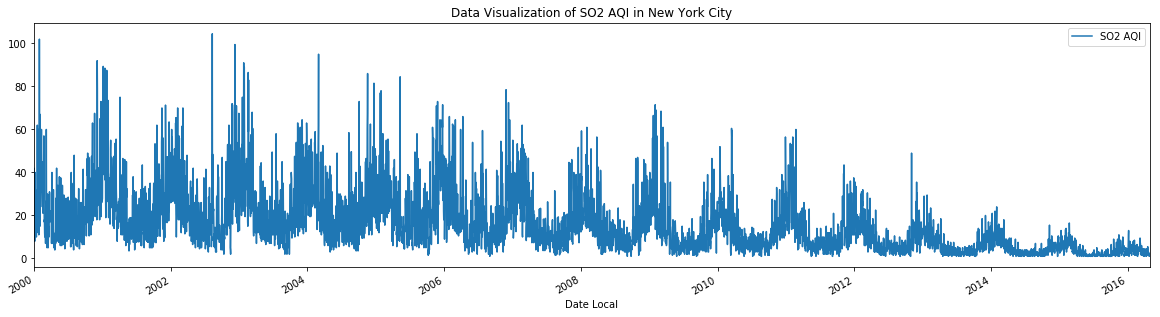

In [7]:
SO2.plot(figsize=(20,5), title="Data Visualization of SO2 AQI in New York City")

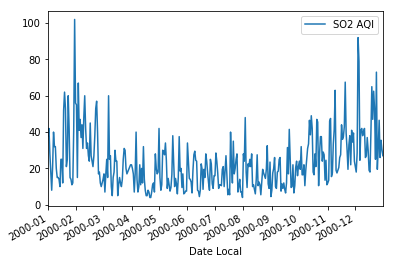

In [35]:
SO2['2000'].plot()

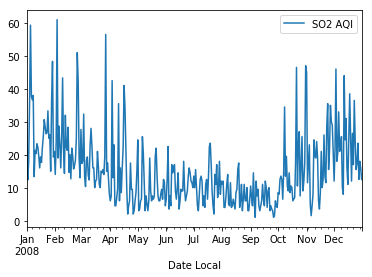

In [36]:
SO2['2008'].plot()

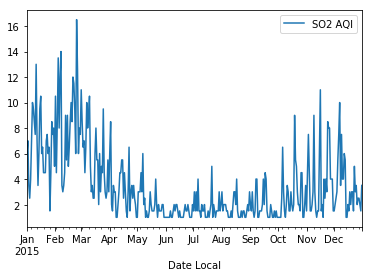

In [37]:
SO2['2015'].plot()

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.tsa.api as smt
from pylab import rcParams

## Log Transformation

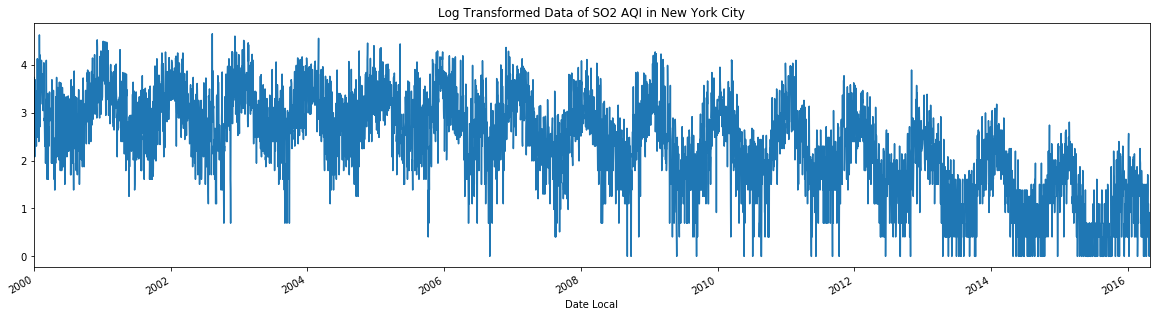

In [10]:
SO2_log = np.log(SO2['SO2 AQI'])
SO2_log.plot(figsize=(20,5), title="Log Transformed Data of SO2 AQI in New York City")

### Resample daily data into monthly data

In [11]:
SO2_log_m = SO2_log.resample('M').mean().to_frame()
SO2_log_m.head()

,SO2 AQI
Date Local,
2000-01-31,3.237296
2000-02-29,3.427829
2000-03-31,2.827540
2000-04-30,2.475744
2000-05-31,2.680464


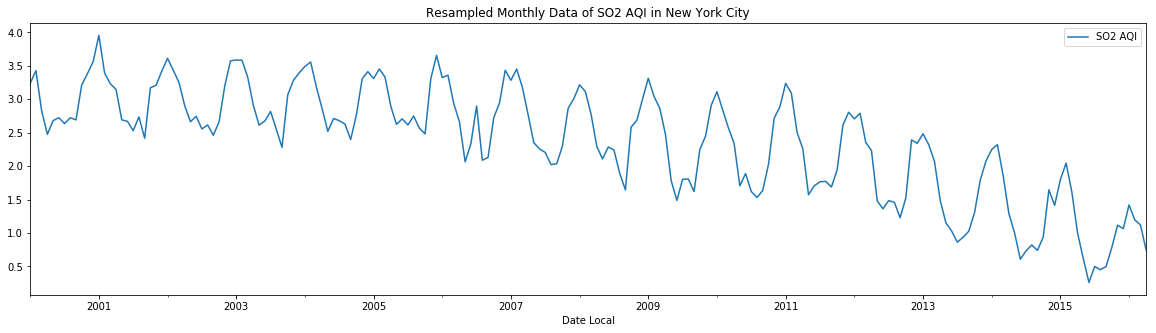

In [12]:
SO2_log_m.plot(figsize=(20,5), title="Resampled Monthly Data of SO2 AQI in New York City")

In [13]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

### Check Stationarity

In [38]:
def adfuller_check(data):
    X = data.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [40]:
adfuller_check(SO2_log_m.iloc[:,0])

ADF Statistic: 3.030554
p-value: 1.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [43]:
def KPSS_check(data):
    X = data.values
    result = kpss(X)
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))

In [44]:
KPSS_check(SO2_log_m.iloc[:,0])

KPSS Statistic: 1.180922
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


### Differencing First Before Applying ARIMA

In [9]:
def acf_pacf_plot_lg(y, lags=None, figsize=(15, 10), style='bmh'):
    fig = plt.figure(figsize=figsize)
    #mpl.rcParams['font.family'] = 'Ubuntu Mono'
    layout = (2, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    plt.plot(y = 0.5)
    pacf_ax = plt.subplot2grid(layout, (1, 0), colspan=2)

    plot_acf(y, lags=lags, ax=acf_ax) 
    acf_ax.axhline(y=0.5, color='r', linestyle='--')
    plot_pacf(y, lags=lags, ax=pacf_ax)
    pacf_ax.axhline(y=-0.5, color='r', linestyle='--')

    plt.tight_layout()
    return

In [14]:
def std_check(order, seasonal_order, data):
    diff_model = ARIMA(order = order, seasonal_order=seasonal_order)
    diff_model.fit(data)
    resid = diff_model.resid()
    std = np.std(resid)
    print('Standard Deviation: %f' % std) 
    acf_pacf_plot_lg(pd.Series(resid), lags = 50)

In [15]:
training, testing = SO2_log_m.iloc[:160].values, SO2_log_m.iloc[160:].values

Standard Deviation: 0.594658


d:\programfile\python3.6.7\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


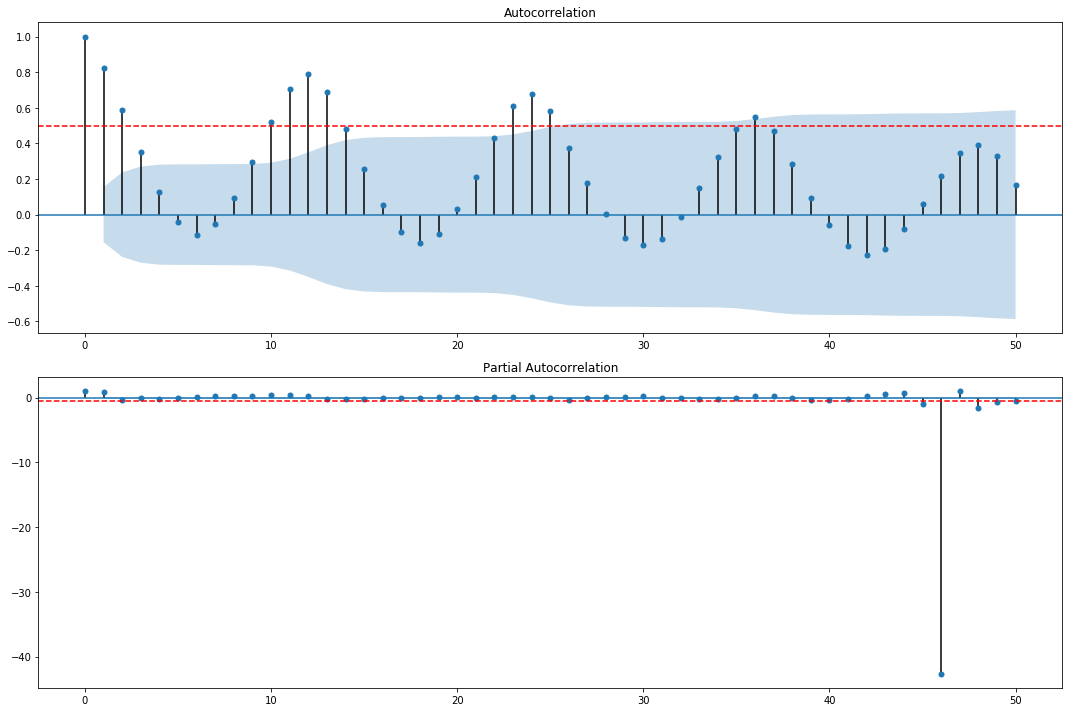

In [16]:
arima1_original = std_check((0,0,0), None, training)

Standard Deviation: 0.339629


d:\programfile\python3.6.7\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


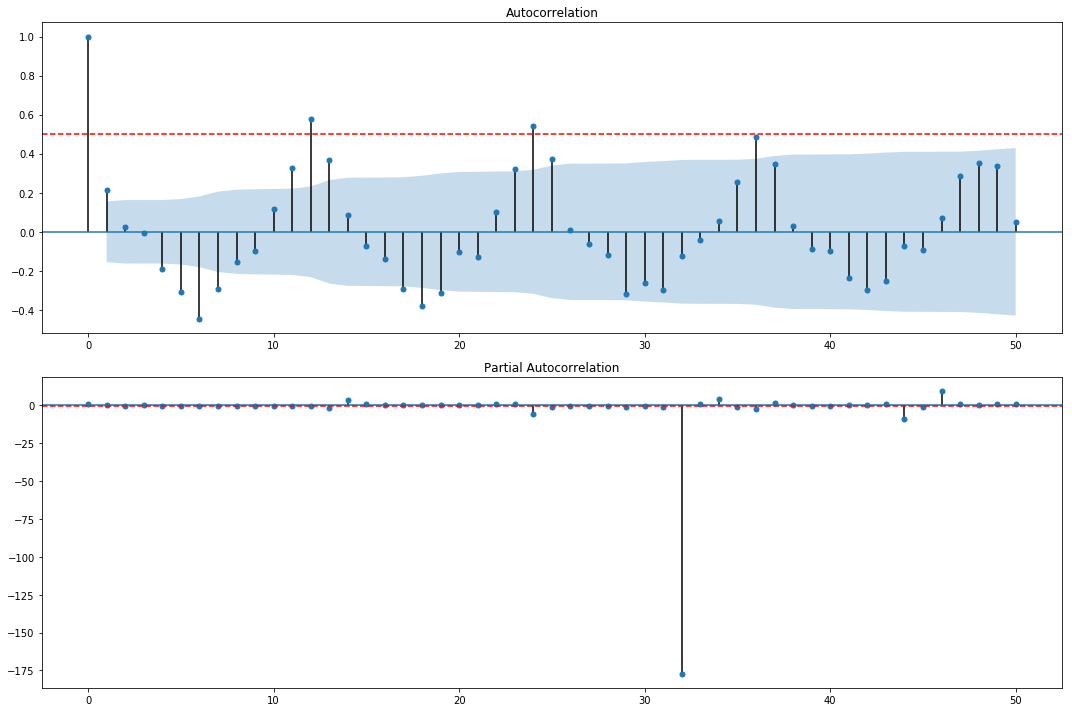

In [17]:
arima1_original = std_check((0,1,0), None, training)

Standard Deviation: 0.424147


d:\programfile\python3.6.7\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


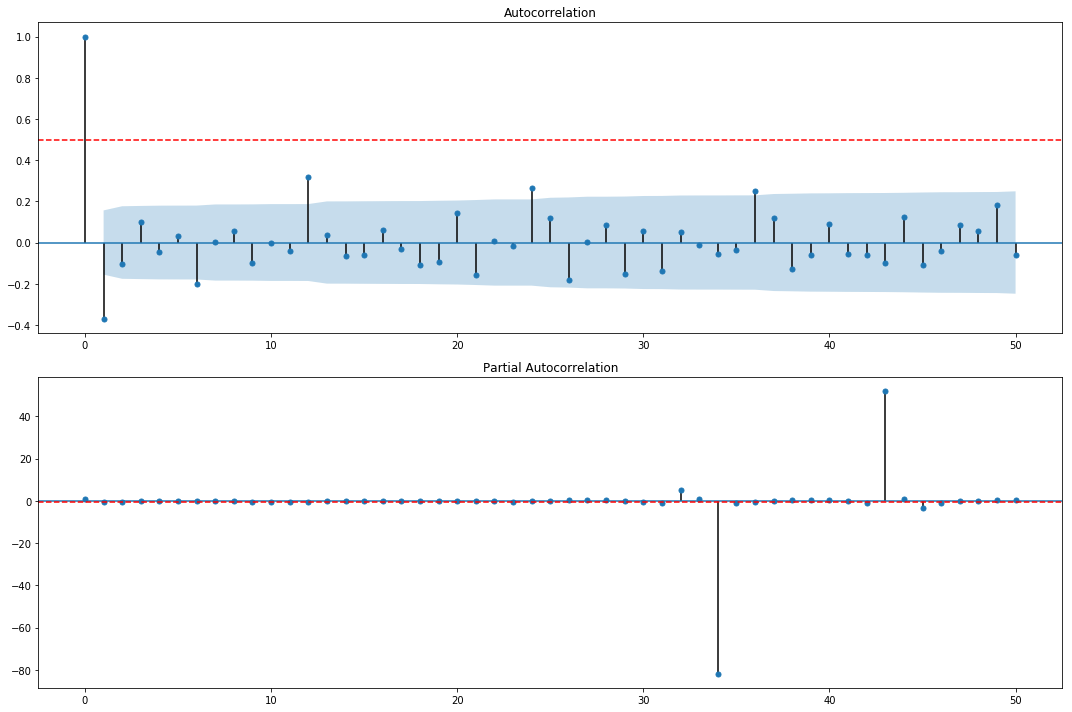

In [18]:
arima1_original = std_check((0,2,0), None, training)

d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Standard Deviation: 0.845484


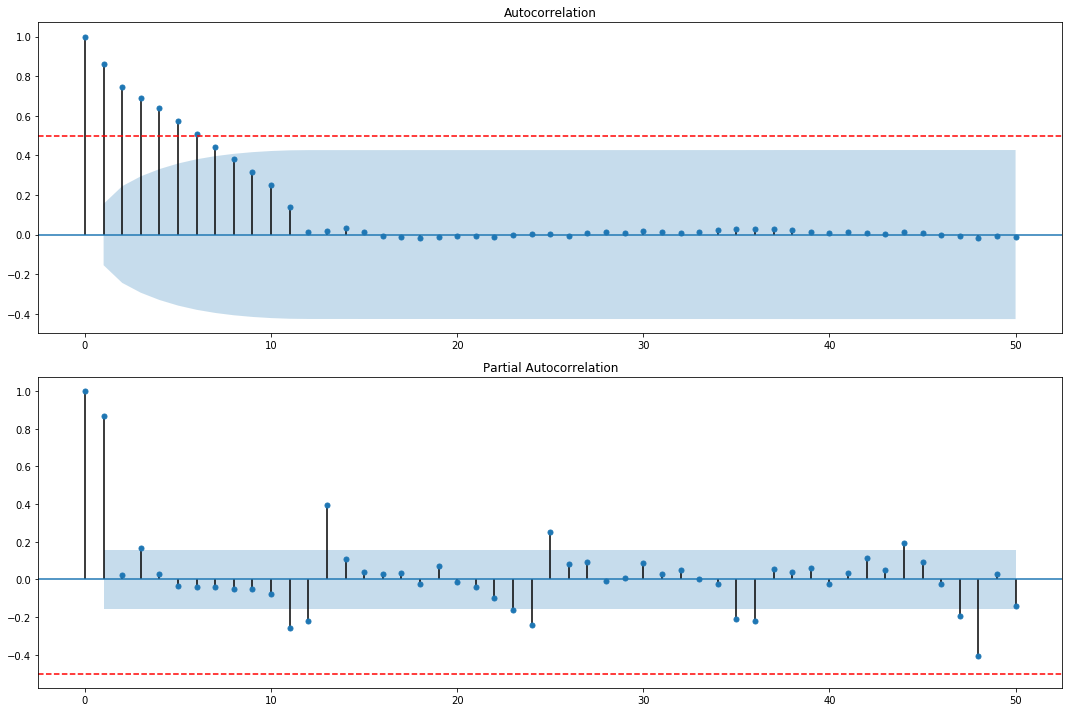

In [19]:
arima1_original = std_check((0,0,0), (0,1,0,12), training)

- Seasonal Differencing is necessary in this model

d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Standard Deviation: 0.397442


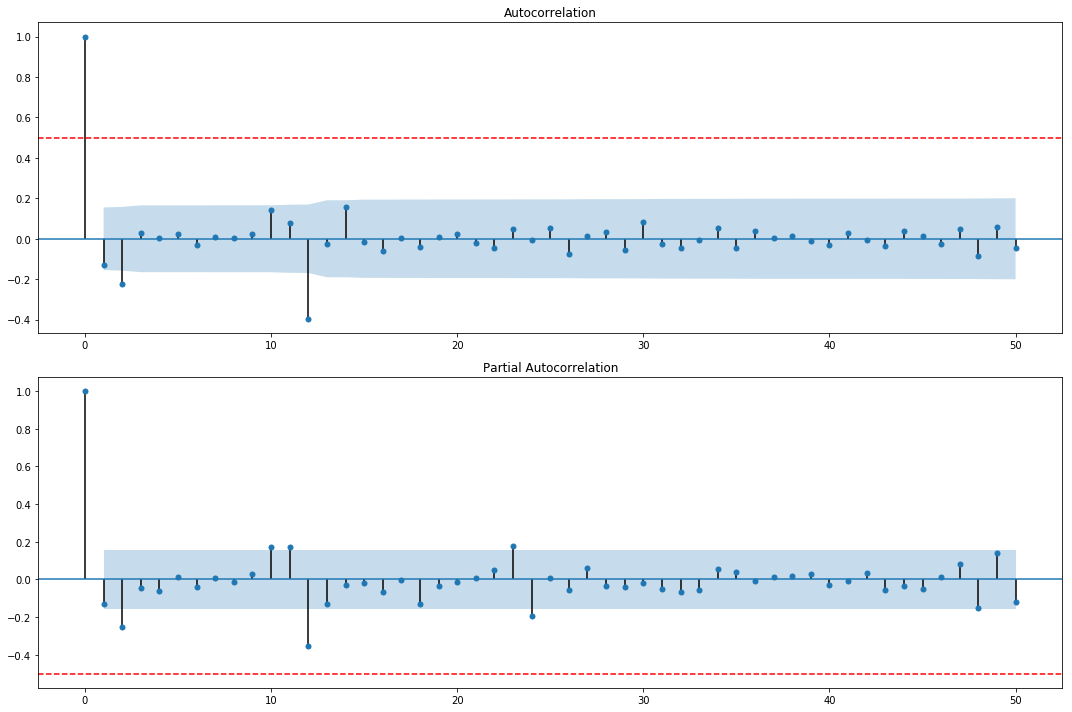

In [20]:
arima1_original = std_check((0,1,0), (0,1,0,12), training)

In [21]:
model = auto_arima(training, start_p=0, max_p=2, start_q=0, max_q=2, d=1, m=12, start_P=0, max_P=0, start_Q=1, max_Q=1, D=1,
                   trace=True, suppress_warning=True, error_action='ignore')
print(model.aic())

d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-1.634, BIC=7.337, Fit time=0.527 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=57.465, BIC=63.446, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=34.285, BIC=43.256, Fit time=0.114 seconds


d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-57.832, BIC=-45.870, Fit time=0.764 seconds


d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-2.398, BIC=6.573, Fit time=0.205 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-56.555, BIC=-41.602, Fit time=1.497 seconds


d:\programfile\python3.6.7\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=-56.668, BIC=-41.715, Fit time=1.928 seconds


d:\programfile\python3.6.7\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=-65.399, BIC=-47.456, Fit time=2.115 seconds


d:\programfile\python3.6.7\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=-15.300, BIC=-0.348, Fit time=0.797 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=-64.422, BIC=-43.489, Fit time=2.358 seconds
Total fit time: 10.361 seconds
-65.39872804666608


d:\programfile\python3.6.7\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
from statsmodels.graphics.gofplots import qqplot

In [23]:
def validation(order, seasonal_order, training, validation):
    model = ARIMA(order = order, seasonal_order = seasonal_order)
    model.fit(training)
    training_fit = model.predict_in_sample()
    validation_fit = model.predict(n_periods=len(validation), return_conf_int=True, alpha=0.5)
        
    #validation_err = np.mean(np.square(validation - validation_fit))
    #print('validation error: %f' % validation_err) 
    
    return model, training_fit, validation_fit

In [24]:
def resid_plot(y, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        resid_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        density_ax = plt.subplot2grid(layout, (1, 0))
        qq_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=resid_ax)
        resid_ax.set_title('Residuals for Monthly Data')
        y.plot(kind='kde', ax=density_ax, title='density')
        qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        

        plt.tight_layout()
    return

In [25]:
def fitting_plt(training_fit, validation):
    
    pred_index=np.arange(160, 196) 
    
    plt.figure(figsize=(20,5), dpi=100)
    plt.plot(training_fit, label='Training')
    plt.plot(SO2_log_m.iloc[0:].values, label='Original Data')
    plt.plot(pred_index , validation[0], label='validation')
    plt.title("Training and Valiation Prediction for Resampled SO2 AQI in NYC")
    
    plt.legend()
    plt.show()

In [26]:
arima_1, train_Fit_1, valid_fit_1 = validation((1,1,2), (0, 1, 1, 12), training, testing)

d:\programfile\python3.6.7\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Training fitting error

In [27]:
train_err = arima_1.resid()
np.mean(np.square(train_err))

0.11472451272531417

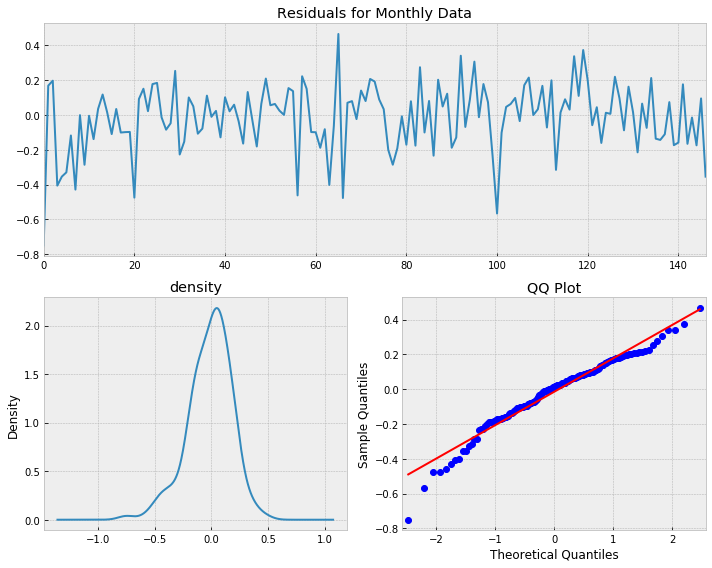

In [28]:
train_err = arima_1.resid()
resid_plot(train_err[13:])

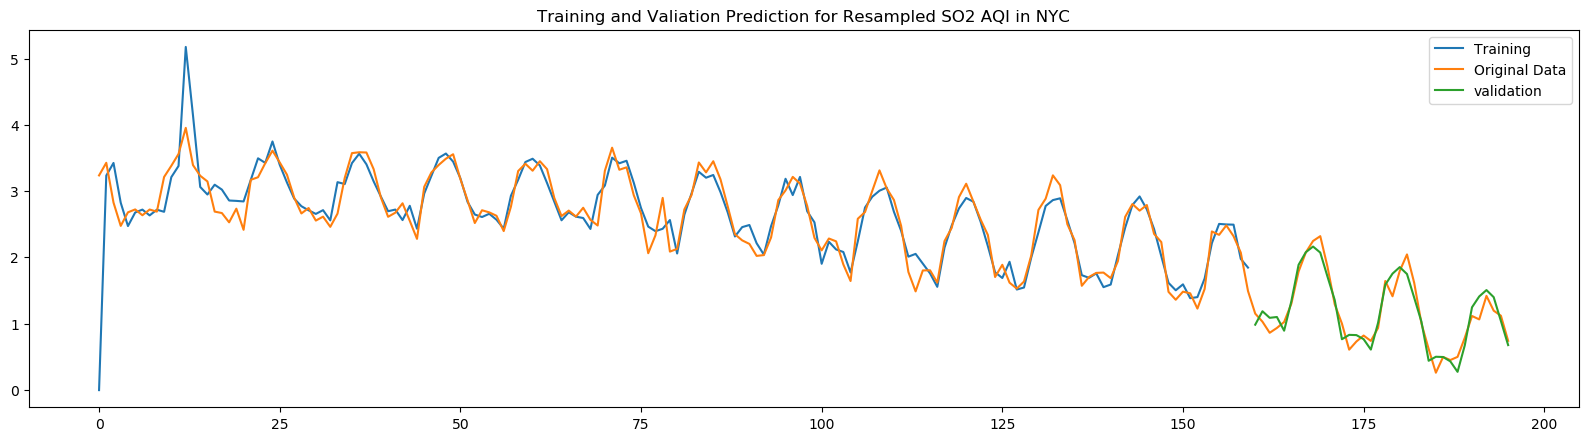

In [30]:
fitting_plt(train_Fit_1, valid_fit_1)

In [31]:
arima_2, train_Fit_2, valid_fit_2 = validation((0,1,2), (0, 1, 1, 12), training, testing)

d:\programfile\python3.6.7\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\programfile\python3.6.7\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [32]:
train_err_2 = arima_2.resid()
np.mean(np.square(train_err_2))

0.11711421943015907

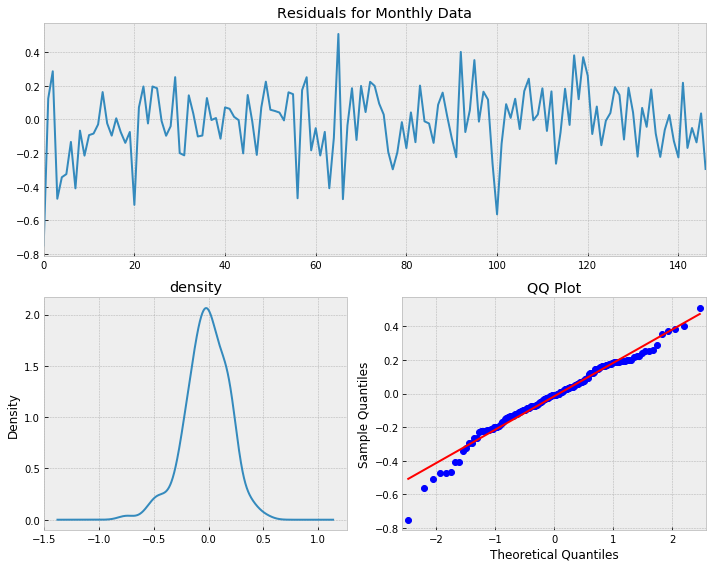

In [33]:
train_err_2 = arima_2.resid()
resid_plot(train_err_2[13:])

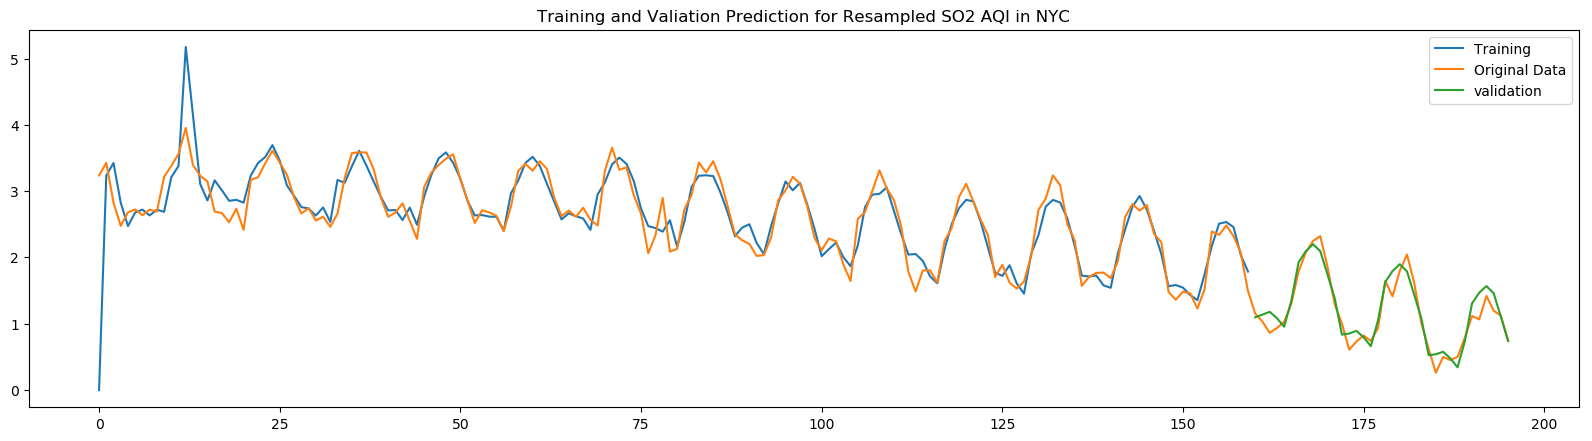

In [34]:
fitting_plt(train_Fit_2, valid_fit_2)

Text(0.5, 1.0, 'Validation Error with 5% Confidence Interval')

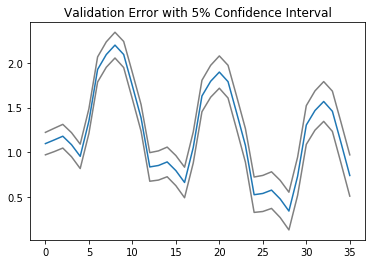

In [47]:
plt.plot(valid_fit_2[0])
plt.plot(valid_fit_2[1], color='grey')
plt.title("Validation Error with 5% Confidence Interval")

In [61]:
SO2_m = SO2.resample('M').mean()

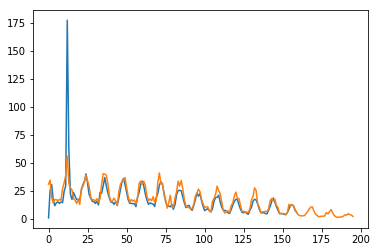

<Figure size 2000x500 with 0 Axes>

In [66]:
plt.plot(np.exp(train_Fit_2))
plt.plot(SO2_m.values)
plt.figure(figsize=(20,5), dpi=100)
plt.show()